In [1]:
# !pip install scipy
# !pip install sklearn
# !pip install numpy
# !pip install pandas
# !pip install matplotlib

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Data from Kaggle.com HR database
data_path = 'HR_comma_sep.csv'

rides = pd.read_csv(data_path)

In [4]:
rides.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


Use Pandas to `get_dummies()`.

In [5]:
dummy_fields = ['sales', 'salary']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['sales', 'salary']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales_IT,sales_RandD,...,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [6]:
quant_features = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'left']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales_IT,sales_RandD,...,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium
0,-0.936463,-1.087239,-1.462814,-0.882010,-0.341224,0,1.788857,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0.752789,0.840679,0.971081,1.220382,1.713379,0,1.788857,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,-2.022412,0.957522,2.593677,1.420610,0.343644,0,1.788857,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.431027,0.899101,0.971081,0.439493,1.028511,0,1.788857,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,-0.976684,-1.145661,-1.462814,-0.841965,-0.341224,0,1.788857,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [7]:
num_total_rows = data.shape[0]

# Save 20% of data for testing
test_data = data.sample(n=round(.20*num_total_rows))

# Remove test data
data = data.drop(test_data.index)

# Split out 50% of remaining data for validation
num_remain_rows = data.shape[0]

train_data = data.sample(n=round(.5*num_remain_rows))

val_data = data.drop(train_data.index)

print(test_data.shape)
print(train_data.shape)
print(val_data.shape)

(3000, 21)
(6000, 21)
(5999, 21)


In [8]:
# Separate the data into features and targets
target_fields = ['left']
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
train_features, train_targets = train_data.drop(target_fields, axis=1), train_data[target_fields]
val_features, val_targets = val_data.drop(target_fields, axis=1), val_data[target_fields]

In [9]:
class neuralnet(object):
    # Create nn function which inits object with provided inputs
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.lr = learning_rate

        # Init weights between input -> hidden, and hidden -> output
        # Note that initial values don't matter much, here creating normal distribution of weights mean 0, sigma 1/sqrt(x)
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))
        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
    
        # Define activation function (here using sigmoid- S shaped curve from 0 to 1)
        self.activation_function = lambda x : 1 / (1 + np.exp(-x))
    
    def train(self, features, targets):
        # Implement nn process here

        n_records = features.shape[0]
        
        # When we update weights we need to store delta (change) so init arrays of weight changes at values 0       
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        
        for X, y in zip(features, targets):
            # Propogating data forward from input to hidden and running through activation function
            hidden_inputs = np.dot(X, self.weights_input_to_hidden)
            hidden_outputs = self.activation_function(hidden_inputs)

            # Propogating data forward from hidden to output, not activating yet because have to first calculate the error
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)
            final_outputs = 1 * final_inputs
            
            # Now backpropogating...
            
            # Difference between actual and prediction
            error = y - final_outputs
            
            # Backprop to the hidden layer, finding hidden's contribution to overall error
            hidden_error = np.dot(error, self.weights_hidden_to_output.T)
            
            # Two errors, now. Output error for updating weights between hidden and output, and...
            output_error_term = error
            # And hidden error, for updating weights between input and hidden layer
            # Multiplying by derivative of activation function (slope)
            # Note that sigmoid also used because derivative relatively simple: x * (1-x)
            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)

            # Update the changes to input to hidden weights, and hidden to output weights
            delta_weights_i_h += hidden_error_term * X[:, None]
            delta_weights_h_o += output_error_term * hidden_outputs[:,None]

        # Now implement Gradient Descent
        # Once run through every node, update weights taking into account average change and learning rate modifier
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records

    
    def run(self, features):
        # Same as above this is just a non-looped run of network that will be used to display results at each step later

        hidden_inputs = np.dot(features, self.weights_input_to_hidden)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)
        final_outputs = 1 * final_inputs
        
        return final_outputs
    
# Function to calc mean of squared errors used as measure of total error in system (what we are hopefully minimizing)
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [10]:
import sys

### Set the hyperparameters here ###
iterations = 1000
learning_rate = 0.1
hidden_nodes = 11
output_nodes = 1

N_i = train_features.shape[1]
network = neuralnet(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.loc[batch].values, train_targets.loc[batch]['left']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['left'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['left'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 99.9% ... Training loss: 0.688 ... Validation loss: 0.688

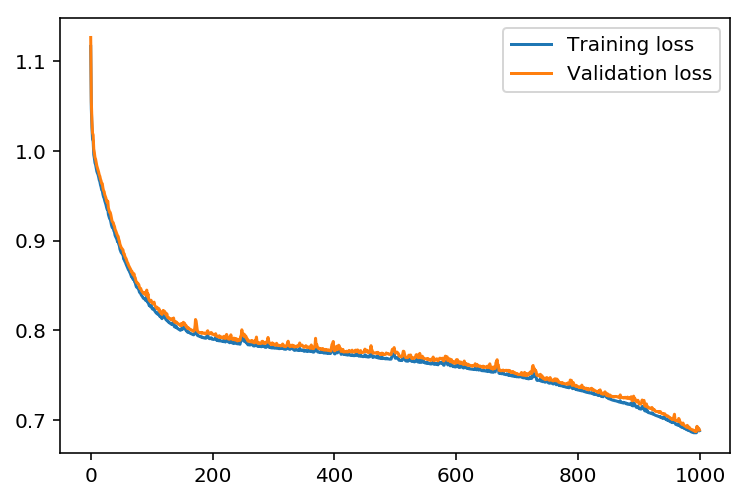

In [11]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

In [12]:
mean, std = scaled_features['left']
predictions = network.run(test_features).T*std + mean

predictions_mean = np.mean(predictions[0])
norm_predictions = []

for prediction in predictions[0]:
    if prediction >= predictions_mean:
        norm_predictions.append(1.0)
    else:
        norm_predictions.append(0.0)

norm_data = []
sum = 0

for value in (test_targets['left']*std + mean).values:
    norm_data.append(round(value))
    if round(value) == 1.0:
        sum += 1
print(sum)

# fig, ax = plt.subplots(figsize=(8,4))
# ax.plot(np.subtract(norm_data, norm_predictions), label='Data')
# ax.set_xlim(left=len(predictions))
# ax.legend()

from sklearn.metrics import confusion_matrix
y_true = norm_data
y_pred = norm_predictions
confusion_matrix(y_true, y_pred, labels=[1, 0])

from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

744


0.72033333333333338

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred, labels=[1, 0])

# [Correctly said employee would leave- True Positive, Incorrectly said employee would leave- False Positive ]
# [ Incorectly said employee would stay- False Negative, Correctly said employee would stay- True Negative]

array([[ 684,   60],
       [ 779, 1477]])